In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve
from skimage import measure
from sympy import Matrix
import cv2

Load the image

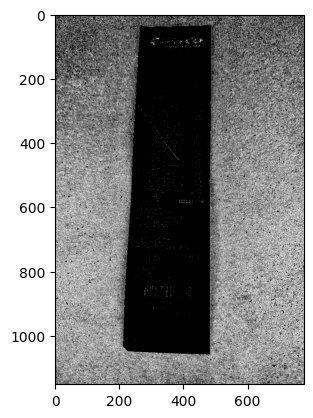

In [2]:
img = cv2.imread('masked_image.png', 0)
plt.imshow(img, cmap='gray')

In [3]:
def show_matrix(image):
    """ Display a formatted matrix of the image """
    m = Matrix(image)
    display(m)

Create the image to test the edge detection methods on.
We will use a 10x10 checkered image

In [ ]:
checkboard = np.array([[1, 0], 
                       [0, 1]])
checkboard = np.kron(checkboard, np.ones((3,3)))
show_matrix(checkboard)

Matrix([
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
[1.0, 1.0, 1.0, 0.0, 0.0, 0.0],
[0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 1.0, 1.0, 1.0],
[0.0, 0.0, 0.0, 1.0, 1.0, 1.0]])

(6, 6)

# Gradient-based methods
## Discrete differential operator
Involves the kernel: $[1 \ 0 \ -1]$

In [5]:
# horizontal kernel
Dx = np.array([1, 0, -1], np.float32).reshape((3,1))
# vertical kernel
Dy = np.array([1, 0, -1], np.float32).reshape((1,3))

Display the image after applying a vertical kernel, as well as a horizontal kernel, separately.
Compare how the results differ.

Text(0.5, 1.0, 'Dy')

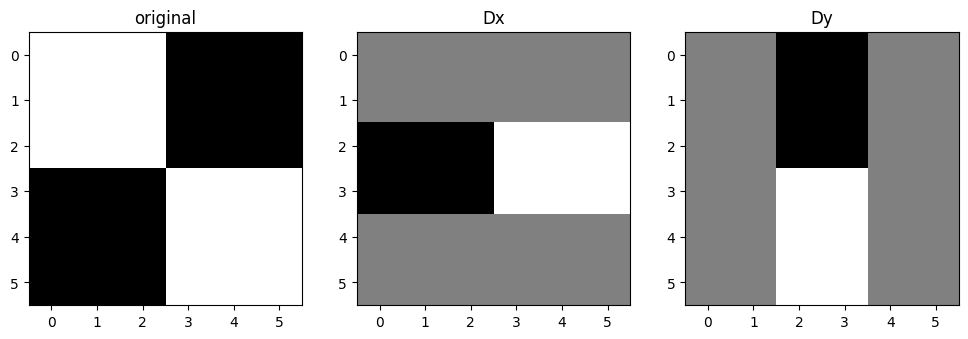

In [22]:
checkboard_x_c = convolve(checkboard, Dx)
checkboard_y_c = convolve(checkboard, Dy)

fig = plt.figure(figsize=(12,12))
fig.add_subplot(1,3,1)
plt.imshow(checkboard, cmap='gray')
plt.title("original")
fig.add_subplot(1,3,2)
plt.imshow(checkboard_x_c, cmap='gray')
plt.title("Dx")
fig.add_subplot(1,3,3)
plt.imshow(checkboard_y_c, cmap='gray')
plt.title("Dy")

- When convolving with a Dx kernel, we observe **vertical** changes in intensity. 
    + i.e.; From the upper-left square to the lower-left square, the intensity switches light->dark, which is why the left-most square in the Dx graph shows up as dark. 
- When convolving with a Dy kernel, we observe **horizontal** changes in intensity. 

We will apply the DDO kernel in **both** vertical and horizontal directions to observe full edge detection effects.

Here is a function that performs the horizontal and vertical convolutions, and returns the magnitude of both.

In [ ]:
def custom_kernel(img, Kx, Ky, alpha=1):
    ''' input: 
            img- a gray scale image
            Kx- kernel for x direction
            Ky- kernel for y direction
            alpha- scaling factor for the kernel
       output: the gray scale edge detection image, and direction matrix theta'''
    # convolution in both directions
    Ix = convolve(img, alpha * Kx)
    Iy = convolve(img, alpha * Ky)

    # calculate the gradient magnitude and direction
    G = np.hypot(Ix, Iy)
    G = G / G.max()
    theta = np.arctan2(Iy, Ix)

    # return combined matrix and angle at which the gradient occurs
    # what is the significance of the angle?
    # the angle indicates the direction of the edge in the image
    # the gradient direction is perpendicular to the edge direction
    # the gradient magnitude indicates the strength of the edge
    # the gradient direction can be used for edge tracking and thinning
    return (G, theta)

### DDO kernel results

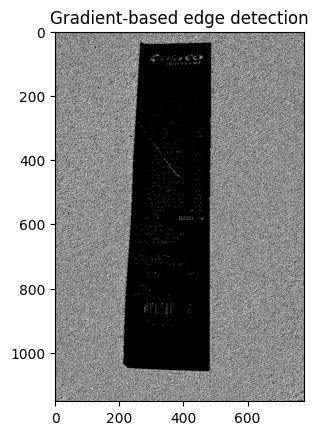

In [9]:
diff_img, theta = custom_kernel(img, Dx, Dy)
plt.title("Gradient-based edge detection")
plt.imshow(diff_img, cmap='gray')

## Gaussian-based edge detection
- The next method involves convolving the image with the Gaussian kernel (based on the Gaussian function).

In [32]:
def gaussian_kernel(kernel_size, sigma=1):
    """creates a kernel of size kernel_size. 
    the bigger the kernel size, 
    the more nearby pixels are taken
    into account. bigger kernel size = more blurring"""
    
    size = int(kernel_size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

Let's test out the Gaussian kernel on a sample matrix of a square:

Matrix([
[0.0, 0.0, 0.0, 0.0, 0.0],
[0.0, 1.0, 1.0, 1.0, 0.0],
[0.0, 1.0, 1.0, 1.0, 0.0],
[0.0, 1.0, 1.0, 1.0, 0.0],
[0.0, 0.0, 0.0, 0.0, 0.0]])

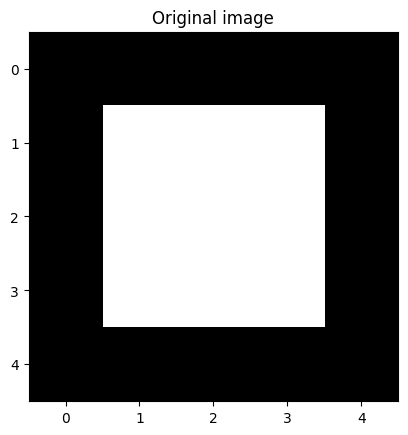

In [34]:
sample = np.zeros((5, 5))
sample[1:4, 1:4] = 1
show_matrix(sample)
plt.title("Original image")
plt.imshow(sample * 255, cmap='gray')

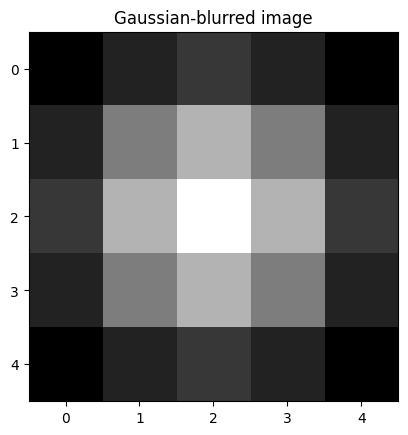

In [ ]:
gaussian = gaussian_kernel(2, 1)
blurred_sample = convolve(sample, gaussian)
plt.title("Gaussian-blurred image")
plt.imshow(blurred_sample, cmap='gray')

### Difference of Gaussians (DOG)
- We will convolve our image with Gaussian kernels at two different intensities (sigma), then find the difference

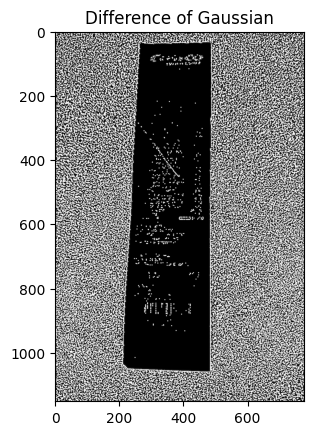

In [13]:
# apply gaussian kernel with sigma 1
checkboard_gauss1 = convolve(img, gaussian_kernel(10, 2))
# apply gaussian kernel with sigma 2
checkboard_gauss2 = convolve(img, gaussian_kernel(10, 1))


# DOG (Difference of Gaussian)
dog = checkboard_gauss1 - checkboard_gauss2
dog_norm = cv2.normalize(dog, None, 0, 255, cv2.NORM_MINMAX)

plt.title("Difference of Gaussian")
plt.imshow(dog_norm, cmap='gray')

## Finding the Outermost Contours
Here is a function that creates a contour map of the detected edges, and returns the longest edge.
This corresponds to the "outline" of the image.

In [38]:
def longest_contour(image):
    contours = measure.find_contours(image, 0.5)

    # Sort contours by length and keep the top 1 
    top5_contours = sorted(contours, key=lambda x: len(x), reverse=True)[:1] # [:1] allows us to keep longest contour

    # Create a clean outline
    outline = np.zeros_like(image)
    for contour in top5_contours:
        for coord in contour:
            outline[int(coord[0]), int(coord[1])] = 1

    return outline

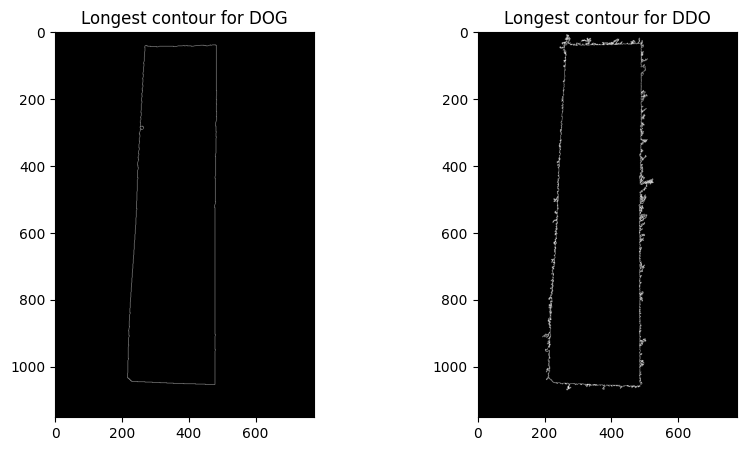

In [44]:
outline_dog = longest_contour(dog_norm)
outline_ddo = longest_contour(diff_img)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(outline_dog, cmap="gray")
axes[0].set_title("Longest contour for DOG")

axes[1].imshow(outline_ddo, cmap="gray")
axes[1].set_title("Longest contour for DDO")

plt.show()
